In [1]:
import os

import matplotlib.pyplot as plt 
import numpy as np 

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets
import torchvision.transforms.functional as TF

In [2]:
!git clone https://github.com/Sivaram46/ProjectAI-DCNN.git

os.chdir('ProjectAI-DCNN')
from DConv import DConv2d
from models import DCNN_Simple, DCNN_Medium
from train_test import train, test
from load_dataset import *

Cloning into 'ProjectAI-DCNN'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24 (delta 10), reused 22 (delta 8), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [3]:
from google.colab import drive 
drive.mount('/drive/')

Mounted at /drive/


In [4]:
train_dataloader, test_dataloader, classes = load_cifar10(64)

for X, y in train_dataloader:
    print('\n\n', X.shape)
    print(y.shape)
    break


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


 torch.Size([64, 3, 32, 32])
torch.Size([64])


In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(DEVICE))

Using cuda device


### Simple CNN model


In [9]:
class CNN_Simple(nn.Module):
    def __init__(self, in_channels: int, n_class: int):
        super(CNN_Simple, self).__init__()

        self.in_channels = in_channels
        self.n_class = n_class

        self.model = nn.Sequential(
            nn.Conv2d(self.in_channels, 8, 3),     
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     

            nn.Conv2d(8, 16, 3),    
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     

            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(7*7*16, self.n_class)      
        )

        self.n_params = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

In [10]:
model = CNN_Simple(in_channels=3, n_class=10).to(DEVICE)
print("Learnable parameters: {:,}".format(model.n_params))

Learnable parameters: 9,242


### Traininig Loop

In [11]:
EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_acc = [], []
test_loss, test_acc = [], []
for e in range(EPOCHS):
    print(f"Epoch {e + 1}\n" + '-' * 50)
    loss, acc = train(train_dataloader, model, loss_fn, optim)
    train_loss += loss; train_acc += acc

    loss, acc = test(test_dataloader, model, loss_fn)
    test_loss.append(loss); test_acc.append(acc)
    
print("Done!")

Epoch 1
--------------------------------------------------
[    0/50000] Loss: 2.304962	Accuracy: 6.2%
[ 6400/50000] Loss: 1.888993	Accuracy: 29.7%
[12800/50000] Loss: 1.779648	Accuracy: 31.2%
[19200/50000] Loss: 1.704879	Accuracy: 43.8%
[25600/50000] Loss: 1.693216	Accuracy: 50.0%
[32000/50000] Loss: 1.736766	Accuracy: 35.9%
[38400/50000] Loss: 2.013005	Accuracy: 29.7%
[44800/50000] Loss: 1.547953	Accuracy: 42.2%

Test Accuracy: 43.7%	 Test Loss: 0.024898 

Epoch 2
--------------------------------------------------
[    0/50000] Loss: 1.503881	Accuracy: 48.4%
[ 6400/50000] Loss: 1.433473	Accuracy: 48.4%
[12800/50000] Loss: 1.751077	Accuracy: 37.5%
[19200/50000] Loss: 1.698400	Accuracy: 34.4%
[25600/50000] Loss: 1.492160	Accuracy: 35.9%
[32000/50000] Loss: 1.707285	Accuracy: 45.3%
[38400/50000] Loss: 1.329365	Accuracy: 53.1%
[44800/50000] Loss: 1.532062	Accuracy: 48.4%

Test Accuracy: 48.5%	 Test Loss: 0.022766 

Epoch 3
--------------------------------------------------
[    0/50000] 

In [12]:
print("Training Accuracy:\t{:.2f}%".format(train_acc[-1]))
print("Test Accuracy:\t\t{:.2f}%".format(test_acc[-1]))

Training Accuracy:	68.75%
Test Accuracy:		59.81%


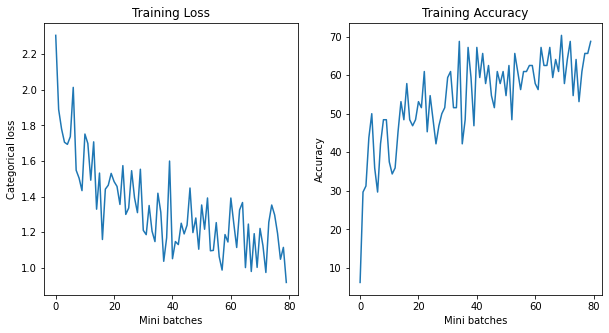

In [13]:
# Analyse the performance
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 5))

ax[0].plot(range(len(train_loss)), train_loss)
ax[0].set_title("Training Loss")
ax[0].set_xlabel('Mini batches')
ax[0].set_ylabel('Categorical loss')

ax[1].plot(range(len(train_acc)), train_acc)
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel('Mini batches')
ax[1].set_ylabel('Accuracy')

plt.show()

### Medium CNN model

In [14]:
class CNN_Medium(nn.Module):
    def __init__(self, in_channels: int, n_class: int):
        super(CNN_Medium, self).__init__()
        
        self.in_channels = in_channels
        self.n_class = n_class

        self.model = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            
            nn.Linear(7*7*128, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_class),
        )

        self.n_params = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )
    
    def forward(self, x):
        logits = self.model(x)
        return logits

In [16]:
model = CNN_Medium(in_channels=3, n_class=10).to(DEVICE)
print("Learnable parameters: {:,}".format(model.n_params))

Learnable parameters: 3,624,650


In [17]:
EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_acc = [], []
test_loss, test_acc = [], []
for e in range(EPOCHS):
    print(f"Epoch {e + 1}\n" + '-' * 50)
    loss, acc = train(train_dataloader, model, loss_fn, optim)
    train_loss += loss; train_acc += acc

    loss, acc = test(test_dataloader, model, loss_fn)
    test_loss.append(loss); test_acc.append(acc)
    
print("Done!")

Epoch 1
--------------------------------------------------
[    0/50000] Loss: 2.300145	Accuracy: 12.5%
[ 6400/50000] Loss: 2.039814	Accuracy: 21.9%
[12800/50000] Loss: 1.723528	Accuracy: 35.9%
[19200/50000] Loss: 1.625978	Accuracy: 34.4%
[25600/50000] Loss: 1.603845	Accuracy: 43.8%
[32000/50000] Loss: 1.741258	Accuracy: 35.9%
[38400/50000] Loss: 1.512795	Accuracy: 43.8%
[44800/50000] Loss: 1.173329	Accuracy: 57.8%

Test Accuracy: 51.7%	 Test Loss: 0.021076 

Epoch 2
--------------------------------------------------
[    0/50000] Loss: 1.263698	Accuracy: 54.7%
[ 6400/50000] Loss: 1.246863	Accuracy: 56.2%
[12800/50000] Loss: 1.168566	Accuracy: 56.2%
[19200/50000] Loss: 1.246432	Accuracy: 60.9%
[25600/50000] Loss: 1.067604	Accuracy: 65.6%
[32000/50000] Loss: 0.977613	Accuracy: 65.6%
[38400/50000] Loss: 1.205344	Accuracy: 62.5%
[44800/50000] Loss: 0.949581	Accuracy: 64.1%

Test Accuracy: 61.1%	 Test Loss: 0.016863 

Epoch 3
--------------------------------------------------
[    0/50000]

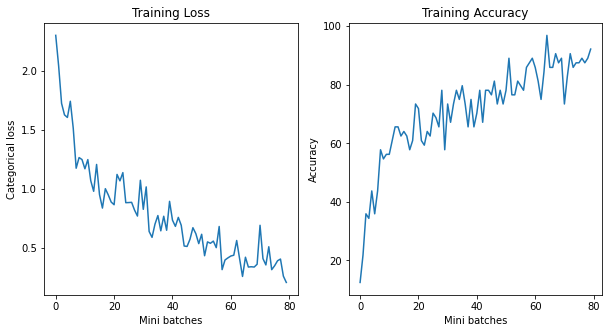

In [18]:
# Analyse the performance
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 5))

ax[0].plot(range(len(train_loss)), train_loss)
ax[0].set_title("Training Loss")
ax[0].set_xlabel('Mini batches')
ax[0].set_ylabel('Categorical loss')

ax[1].plot(range(len(train_acc)), train_acc)
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel('Mini batches')
ax[1].set_ylabel('Accuracy')

plt.show()

In [19]:
torch.save(model.state_dict(), '/drive/MyDrive/Package/cnn_medium_cifar10.pth')
print("Model saved!!")

Model saved!!
